In [7]:
from types import SimpleNamespace

import numpy as np
import scipy as sc
from scipy import optimize
import sympy as sm
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from sympy import *
from sympy import Eq 
import ipywidgets as widgets
from ipywidgets import interact
from scipy.optimize import minimize


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2



from scipy import interpolate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

 First, we want to see how the $L^*(\tilde{w})$ comes out using math solvers without any use of parameters-values. We start by defining all our symbols and then taking the first order conditions and solve for $L^*(\tilde{w})$. We see that the results we get can be simplified, by deviding and multiplying, to the version provided in the question, and therefore have verified symbolically that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [8]:
# Define the symbols
L, w, tau, alpha, nu, kappa, G = symbols('L w tau alpha nu kappa G')

# Calculate w_tilde
w_tilde = (1 - tau) * w

# Define the utility function
C = kappa + w_tilde * L
V = log(C**alpha * G**(1-alpha)) - nu * L**2 / 2

# Differentiate the utility function
dV_dL = diff(V, L)

# Set the derivative equal to zero and solve for L
L_star_formula = solve([dV_dL], [L])
L_star_formula_positive = L_star_formula[1][0]
pprint(L_star_formula_positive)

         ____________________________
        ╱   ⎛     2        2    2  ⎞ 
κ⋅ν + ╲╱  ν⋅⎝4⋅α⋅w ⋅(τ - 1)  + κ ⋅ν⎠ 
─────────────────────────────────────
            2⋅ν⋅w⋅(τ - 1)            


 We also want to see if the values from both the provided formula and the one gotten through optimization reach the same answers given the $\tilde{w} = (1-\tau)*w$, for $G\in\left\{1.0 , 2.0\right\}$.

 We start by defining our baseline parameters, then we define the utility (using $\tilde{w}$) and the values for G. Then we print out the values for $L^*$ given both G=1.0 and G=2.0 that are found through both optimization and the given formula. We found that the results are the same, and therefore conclude that we have verified the function for $L^*(\tilde{w})$


In [12]:
# Baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1/(2*16**2)
w = 1.0
tau = 0.30
w_tilde = (1-tau)*w
G_values = [1.0, 2.0]

# Define the utility function
def utility(L, w_tilde, G):
    C = kappa + w_tilde*L
    utility = np.log(C**alpha * G**(1-alpha)) - nu*L**2/2
    return -utility  

# Define the given formula to compare 
def L_star_formula(w_tilde):
    return (-kappa + np.sqrt(kappa**2 + 4*alpha/nu*w_tilde**2)) / (2*w_tilde)

for G in G_values:
    # Calculate L_star using optimization
    L_star_opt = optimize.minimize(utility, 1, args=(w_tilde, G), bounds=[(0, 24)]).x[0]
    # Calculate L_star using the formula
    L_star_formula_val = L_star_formula(w_tilde)
    print(f"For G = {G}, L_star (optimized) = {L_star_opt:.2f}, L_star (formula) = {L_star_formula_val:.2f}")

For G = 1.0, L_star (optimized) = 15.30, L_star (formula) = 15.30
For G = 2.0, L_star (optimized) = 15.30, L_star (formula) = 15.30


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

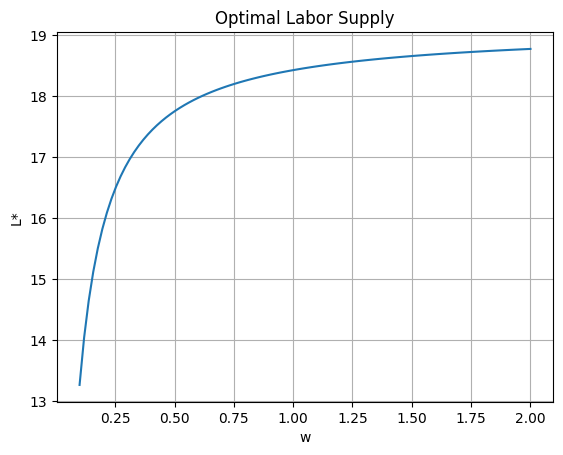

In [10]:
# Define the baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1.0 / (2 * 16**2)
w = 1.0
tau = 0.30

# Define the range of w values
w_values = np.linspace(0.1, 2.0, 100)

# Calculate the optimal labor supply for each w value
L_star_values = (-kappa + np.sqrt(kappa**2 + 4 * alpha / nu * (1 - tau) * w_values**2)) / (2 * (1 - tau) * w_values)

# Plot the results
plt.plot(w_values, L_star_values)
plt.xlabel('w')
plt.ylabel('L*')
plt.title('Optimal Labor Supply')
plt.grid(True)
plt.show()

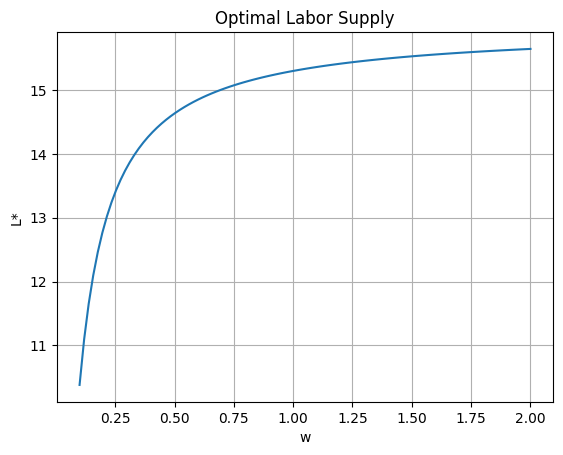

In [13]:
# Define the baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1.0 / (2 * 16**2)
w = 1.0
tau = 0.30

# Define the range of w values
w_values = np.linspace(0.1, 2.0, 100)

# Calculate the optimal labor supply for each w value
L_star_values = [L_star_formula((1 - tau) * w) for w in w_values]

# Plot the results
plt.plot(w_values, L_star_values)
plt.xlabel('w')
plt.ylabel('L*')
plt.title('Optimal Labor Supply')
plt.grid(True)
plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [ ]:
# write your code here

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [ ]:
# write your code here

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [ ]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [ ]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

First, we numerically solve for the $\ell_t$ that maximizes profit given the profit equation, which we do through optimization. Secondly we calculate the opimal labor supply given the formula in **Question 1**. 

The code below does the following: 
 * Defines the profit function based on the problem statement.  
 * Calculates the value of labor (ell) that maximizes profit using a numerical optimization method (the minimize function from scipy.optimize). This value is the result of the optimization and is saved in optimal_ell. 
 * The code also calculates the value of labor that maximizes profit according to the given formula, and this value is saved in formula_ell. 
 * Finally, it prints the values of optimal_ell and formula_ell, as well as their difference, for each value of kappa. 

In [ ]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
eta = 0.5
w = 1.0
kappas = [1.0, 2.0]

def profit(ell, kappa, eta, w):
    return -kappa * ell**(1-eta) + w * ell

for kappa in kappas:
    # Find optimal ell through optimization
    result = minimize(profit, x0=0, args=(kappa, eta, w))  # x0=0 is an initial guess for ell
    optimal_ell = result.x[0]  # This extracts the optimal ell from the result

    # Calculate optimal ell from the given formula
    formula_ell = ((1 - eta) * kappa / w) ** (1 / eta)

    # Calculate the difference
    difference = abs(optimal_ell - formula_ell)

    print(f"For kappa = {kappa}, the optimal \u2113 that maximizes profit is: {optimal_ell:.2f}")
    print(f"Optimal \u2113 as per the formula is: {formula_ell:.2f}")
    print(f"The difference between the two methods is: {difference:.2f}")
    print("--------------------------------------------------")



For kappa = 1.0, the optimal ℓ that maximizes profit is: 0.25
Optimal ℓ as per the formula is: 0.25
The difference between the two methods is: 0.00
--------------------------------------------------
For kappa = 2.0, the optimal ℓ that maximizes profit is: 1.00
Optimal ℓ as per the formula is: 1.00
The difference between the two methods is: 0.00
--------------------------------------------------


As indicated by the results, the optimal $\ell$ that maximizes profit when $\kappa\in\left\{1.0 , 2.0\right\}$ given the problem is the same when it is derived from using the formula given in **Question 1**.

I want to add the difference in profit and also plot on a graph how the profit changes with the two different kappas in ONE plot instead of two.

For kappa = 1.0, the optimal ℓ that maximizes profit is: 0.2499964502963941


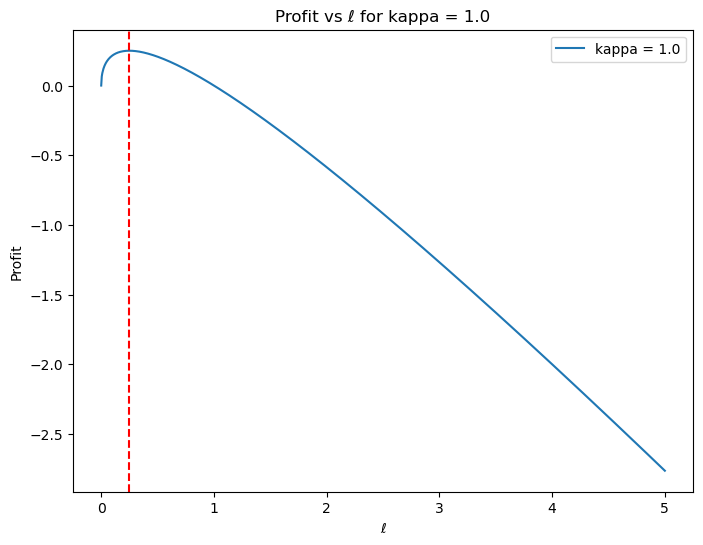

For kappa = 2.0, the optimal ℓ that maximizes profit is: 0.9999975155570141


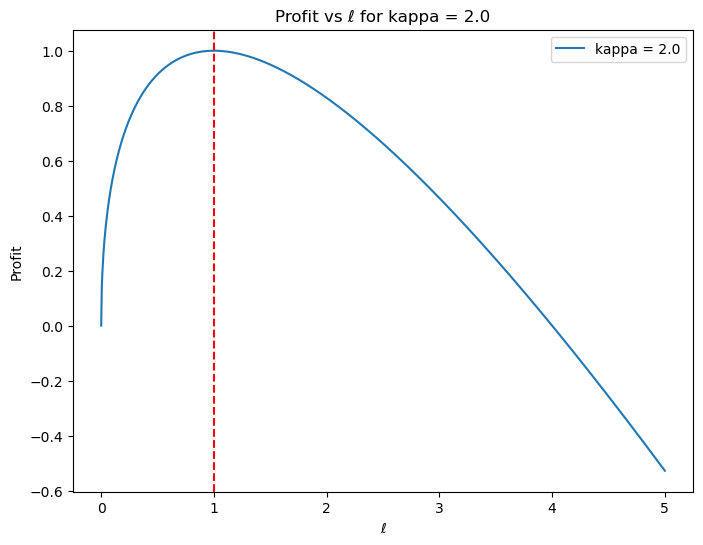

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
eta = 0.5
w = 1.0
kappas = [1.0, 2.0]

# Define the profit function
def profit(ell, kappa, eta, w):
    return -kappa * ell**(1-eta) + w * ell

# Create a range of values for ell
ell_values = np.linspace(0, 5, 1000)

# For each kappa
for kappa in kappas:
    # Find the optimal ell
    result = minimize(profit, x0=0, args=(kappa, eta, w))
    optimal_ell = result.x[0]
    
    # Print the optimal ell
    print(f"For kappa = {kappa}, the optimal \u2113 that maximizes profit is: {optimal_ell}")
    
    # Calculate the profit for each ell
    profit_values = -profit(ell_values, kappa, eta, w)
    
    # Plot the profit
    plt.figure(figsize=(8,6))
    plt.plot(ell_values, profit_values, label=f'kappa = {kappa}')
    plt.axvline(x=optimal_ell, linestyle='--', color='red')  # Add a vertical line at the optimal ell
    plt.xlabel('\u2113')
    plt.ylabel('Profit')
    plt.legend()
    plt.title(f'Profit vs \u2113 for kappa = {kappa}')
    plt.show()

For kappa = 1.0: optimal labor = 0.25, corresponding profit = 0.25


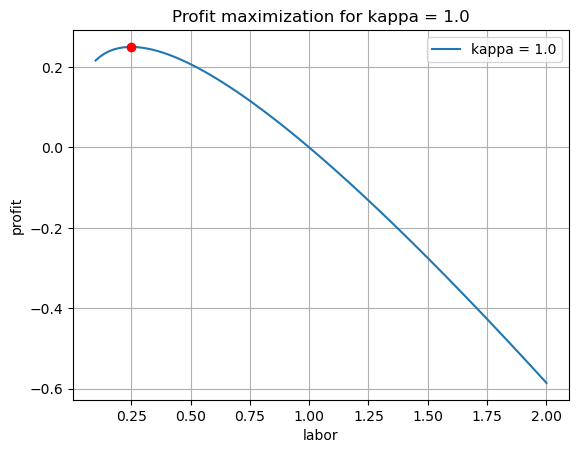

For kappa = 2.0: optimal labor = 1.0, corresponding profit = 1.0


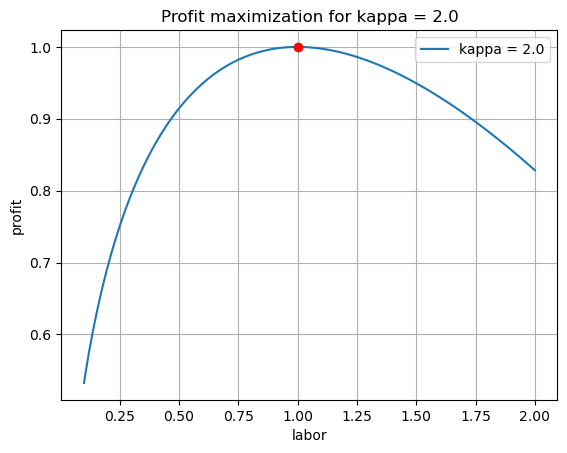

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters in problem 2
eta = 0.5
w = 1.0
kappa_values = [1.0, 2.0]

# Define the profit function
def profit(l, kappa):
    return kappa * l**(1 - eta) - w * l

# Define the labor function that supposed to maximize the profits
def optimal_labor(kappa):
    return ((1 - eta) * kappa / w)**(1 / eta)

# Verify the solution for each kappa
for kappa in kappa_values:
    # Calculate optimal labor
    l_opt = optimal_labor(kappa)
    
    # Calculate the corresponding profit
    profit_opt = profit(l_opt, kappa)
    
    # Print the results
    print(f"For kappa = {kappa}: optimal labor = {l_opt}, corresponding profit = {profit_opt}")

    # Plot the profit function for a range of labor values
    labor_values = np.linspace(0.1, 2, 100)
    profit_values = profit(labor_values, kappa)
    
    plt.figure()
    plt.plot(labor_values, profit_values, label=f"kappa = {kappa}")
    plt.plot(l_opt, profit_opt, 'ro') # Mark the optimal labor and the corresponding profit
    plt.xlabel('labor')
    plt.ylabel('profit')
    plt.title(f"Profit maximization for kappa = {kappa}")
    plt.legend()
    plt.grid(True)
    plt.show()

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

The second part of your problem involves a dynamic version of the same model. The demand-shock, $\kappa_t$, now follows an autoregressive model of order 1 (AR(1)) in logs, and there are fixed costs, $\iota$, associated with hiring or firing employees. Future profits are discounted with a monthly factor of $R$.

The AR(1) model in logs is a stochastic process where the log of the demand-shock at time $t$ is a function of the log of the demand-shock at time $t-1$ and a random shock, $\epsilon_t$.

Your task is to calculate the expected value of the hair salon over a planning horizon of 120 months (10 years), given this new model and the labor policy from the first question. The expected value, $H$, is the average of $h$ over $K$ random shock series.

Here's a step-by-step plan to tackle this:

Define the given parameters, including the new ones.
Generate the shock series, $\epsilon_t$, following a normal distribution with mean $-0.5\sigma_{\epsilon}^2$ and standard deviation $\sigma_{\epsilon}$, for $K$ different series and 120 time steps.
Calculate the demand-shock series, $\kappa_t$, using the AR(1) model for each series.
Calculate the labor series, $\ell_t$, using the labor policy from the first question for each series.
Calculate $h$ for each series using the formula given in the question.
Calculate the expected value of the salon, $H$, as the average of $h$ over all series.
Print the result.


In [ ]:
import numpy as np

# Define the new parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01)**(1/12)
K = 1000  # Possibly add an algorithm to speed it up look at problem set 5 and lectures Algorithms basics, Searching and recursion, Sorting

# Define the labor function that is supposed to maximize the profits
def optimal_labor(kappa):
    return ((1 - eta) * kappa / w)**(1 / eta)

# Generate the shock series
epsilon = np.random.normal(-0.5*sigma_epsilon**2, sigma_epsilon, (K, 120))

# Initialize the demand-shock series and the labor series
kappa = np.zeros((K, 120))
labor = np.zeros((K, 120))

# Calculate the demand-shock and labor series
kappa[:, 0] = np.exp(rho * np.log(1) + epsilon[:, 0])  # kappa for t = 0
labor[:, 0] = optimal_labor(kappa[:, 0])  # labor for t = 0
for t in range(1, 120):
    kappa[:, t] = np.exp(rho * np.log(kappa[:, t-1]) + epsilon[:, t])
    labor[:, t] = optimal_labor(kappa[:, t])

# Calculate h for each series
h = np.zeros(K)
for t in range(120):
    h += R**(-t) * (kappa[:, t] * labor[:, t]**(1 - eta) - w * labor[:, t] - iota * (labor[:, t] != labor[:, t-1]))

# Calculate the expected value of the salon
H = np.mean(h)

# Print the result
print(f"The expected value of the salon is {H}")

The expected value of the salon is 27.93337038107023


In [ ]:
import numpy as np

# Define the new parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01)**(1/12)

# Define the labor function that is supposed to maximize the profits
def optimal_labor(kappa):
    return ((1 - eta) * kappa / w)**(1 / eta)

# Set a tolerance for the change in H
tolerance = 1e-6

# Set a maximum K value to prevent an infinite loop
max_K = 1000

# Initialize K
K = 1

# Initialize previous H
prev_H = 0

# Loop until K reaches max_K
while K <= max_K:
    # Generate the shock series
    epsilon = np.random.normal(-0.5*sigma_epsilon**2, sigma_epsilon, (K, 120))

    # Initialize the demand-shock series and the labor series
    kappa = np.zeros((K, 120))
    labor = np.zeros((K, 120))

    # Calculate the demand-shock and labor series
    kappa[:, 0] = np.exp(rho * np.log(1) + epsilon[:, 0])  # kappa for t = 0
    labor[:, 0] = optimal_labor(kappa[:, 0])  # labor for t = 0
    for t in range(1, 120):
        kappa[:, t] = np.exp(rho * np.log(kappa[:, t-1]) + epsilon[:, t])
        labor[:, t] = optimal_labor(kappa[:, t])

    # Calculate h for each series
    h = np.zeros(K)
    for t in range(120):
        h += R**(-t) * (kappa[:, t] * labor[:, t]**(1 - eta) - w * labor[:, t] - iota * (labor[:, t] != labor[:, t-1]))

    # Calculate the expected value of the salon
    H = np.mean(h)
    
    # If the change in H is less than the tolerance, stop the loop
    if np.abs(H - prev_H) < tolerance:
        break
    # If not, set the current H as the previous H and increase K
    prev_H = H
    K += 1

# Print the result
print(f"The expected value of the salon is {H} for K = {K}")


The expected value of the salon is 27.600736876071466 for K = 1001


The expected value of the salon, 27.740888508502795. H is the average of h across all series where h is the sum of discounted profits for each series (each month in a 10 year period). So, H=27.740888508502795 represents an average profit over the 10-year period.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [ ]:
T = 120  # Number of months
Delta = 0.05  # The threshold for labor adjustment

# Define the new labor policy
def labor_policy(l_last, kappa):
    l_star = ((1 - eta) * kappa / w)**(1 / eta)
    if abs(l_last - l_star) > Delta:
        return l_star
    else:
        return l_last

# Generate shock series and calculate H using the new labor policy
np.random.seed(0)
H_new_policy = 0.0
for _ in range(K):
    kappa = 1.0
    l_last = 0.0
    total_profit = 0.0
    for _ in range(T):
        epsilon = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon)
        kappa = np.exp(rho*np.log(kappa) + epsilon)
        l = labor_policy(l_last, kappa)
        total_profit += R**(-t) * (kappa*l**(1-eta) - w*l - int(l != l_last)*iota)
        l_last = l
    H_new_policy += total_profit

H_new_policy /= K

print(f"H with the new labor policy: {H_new_policy}")


H with the new labor policy: 27.11644053737805


Comparing the answer of **Question 3** to the answer to **Question 2**, we can see that the new labor policy does not improve profitability. 

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [ ]:
# Initialize a list to store the values of H for different Delta values
H_values = []
Delta_values = np.linspace(0.0, 1.0, 1000)  # Consider a range of Delta values between 0 and 1

# Calculate H for each Delta value
for Delta in Delta_values:
    H_new_policy = 0.0
    for _ in range(K):
        kappa = 1.0
        l_last = 0.0
        total_profit = 0.0
        for _ in range(T):
            epsilon = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon)
            kappa = np.exp(rho*np.log(kappa) + epsilon)
            l = labor_policy(l_last, kappa)
            total_profit += R**(-t) * (kappa*l**(1-eta) - w*l - int(l != l_last)*iota)
            l_last = l
        H_new_policy += total_profit

    H_new_policy /= K
    H_values.append(H_new_policy)

# Find the Delta value that maximizes H
optimal_Delta = Delta_values[np.argmax(H_values)]

print(f"The optimal Delta is {optimal_Delta}")


KeyboardInterrupt: 

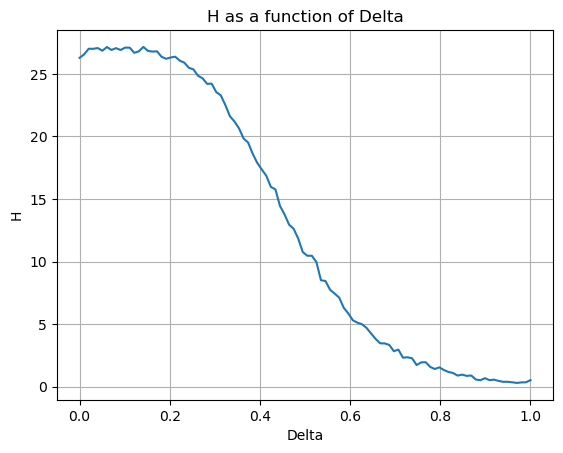

In [ ]:
plt.plot(Delta_values, H_values)
plt.xlabel("Delta")
plt.ylabel("H")
plt.title("H as a function of Delta")
plt.grid(True)
plt.show()



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



The choice of policy would largely depend on the specifics of the business, and there may be different strategies that could potentially improve profitability. Here, however, we are looking for a policy that would optimize the use of labor in response to the demand shock.

A potential alternative policy could be to implement a hybrid policy where you combine both the policy in question 3 and another policy where you hire or fire hairdressers based on a threshold of expected future demand.

This policy could look something like this:

If the absolute difference between current and optimal labor (calculated from the policy in question 1) exceeds $\Delta$, hire or fire workers as required.

However, if the expected future demand (based on the AR(1) demand-shock model) exceeds a certain threshold, hire additional workers in anticipation of this increased demand, even if the optimal labor calculated from the policy in question 1 doesn't suggest this.

This way, you are not only reacting to the current demand but also preparing for future demand. This could potentially reduce costs associated with hiring and training new workers.

The implementation of this policy in Python would involve modifying the labor_policy function and running the simulation again.

Here's a skeleton of how you might modify the labor_policy function. You will need to decide on how to compute the expected future demand and what threshold to use for hiring additional workers.



def labor_policy(l_last, kappa, future_demand):
    l_star = ((1 - eta) * kappa / w)**(1 / eta)
    if abs(l_last - l_star) > Delta:
        return l_star
    elif future_demand > SOME_THRESHOLD:
        return l_last + SOME_AMOUNT
    else:
        return l_last

Then you would need to update the calculation of H_new_policy to include this future_demand in the labor_policy function.

Please note that this is just one of the many possible policies you might consider. Your specific choice would depend on your understanding of the problem, the business, and the implications of different policies. It would be a good idea to discuss potential policies with colleagues or classmates to get different perspectives.

Choosing these parameters would typically be an empirical process based on historical data and business-specific information. But since we don't have that, we can make some reasonable assumptions.

For SOME_THRESHOLD, we could use the average of kappa (demand shock) over a certain past period or we could use a fixed percentile of the observed kappa values, such as the 75th percentile. For instance, if the expected future demand is higher than 75% of what we have seen in the past, we might decide to hire more hairdressers.

As for SOME_AMOUNT, this would determine how many additional hairdressers you would hire when the expected future demand exceeds the threshold. A simple approach might be to hire an additional fixed number of hairdressers (e.g., one additional hairdresser). Alternatively, the amount could be a function of the difference between the expected future demand and the threshold. For example, you could hire an additional hairdresser for every unit that the expected future demand exceeds the threshold.

Remember, these are just assumptions. The real world is likely to be more complex and unpredictable. It would be a good idea to test your policy under different conditions and assumptions to ensure that it performs well in a variety of scenarios.

In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [ ]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
# write your code here